# Document type distribution

## Compare distribution of documents by type, and over time, in the following document populations:
- untagged 
- labelled
- filtered
- tagged to level 1 only
- tagged to level2 or lower

In [108]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import functools
import matplotlib as mpl
import json
%matplotlib inline
inline_rc = dict(mpl.rcParams)

# Read in  data

In [109]:
#read in untagged content to describe content with no taxons

untagged = pd.read_csv('../../data/untagged_content.csv')
untagged['first_published_at'] = pd.to_datetime(untagged['first_published_at'])
untagged.index = untagged['first_published_at']

In [110]:
labelled = pd.read_csv('../../data/labelled.csv')

In [111]:
filtered = pd.read_csv('../../data/filtered.csv')

In [112]:
taxons = pd.read_csv('../../data/clean_taxons.csv')

In [113]:
level1_tagged = pd.read_csv('../../data/labelled_level1.csv')
level1_tagged['first_published_at'] = pd.to_datetime(level1_tagged['first_published_at'])
level1_tagged.index = level1_tagged['first_published_at']

In [114]:
level2_tagged = pd.read_csv('../../data/labelled_level2.csv')
level2_tagged['first_published_at'] = pd.to_datetime(level2_tagged['first_published_at'])
level2_tagged.index = level2_tagged['first_published_at']

## Frequency of documents in each category of document type

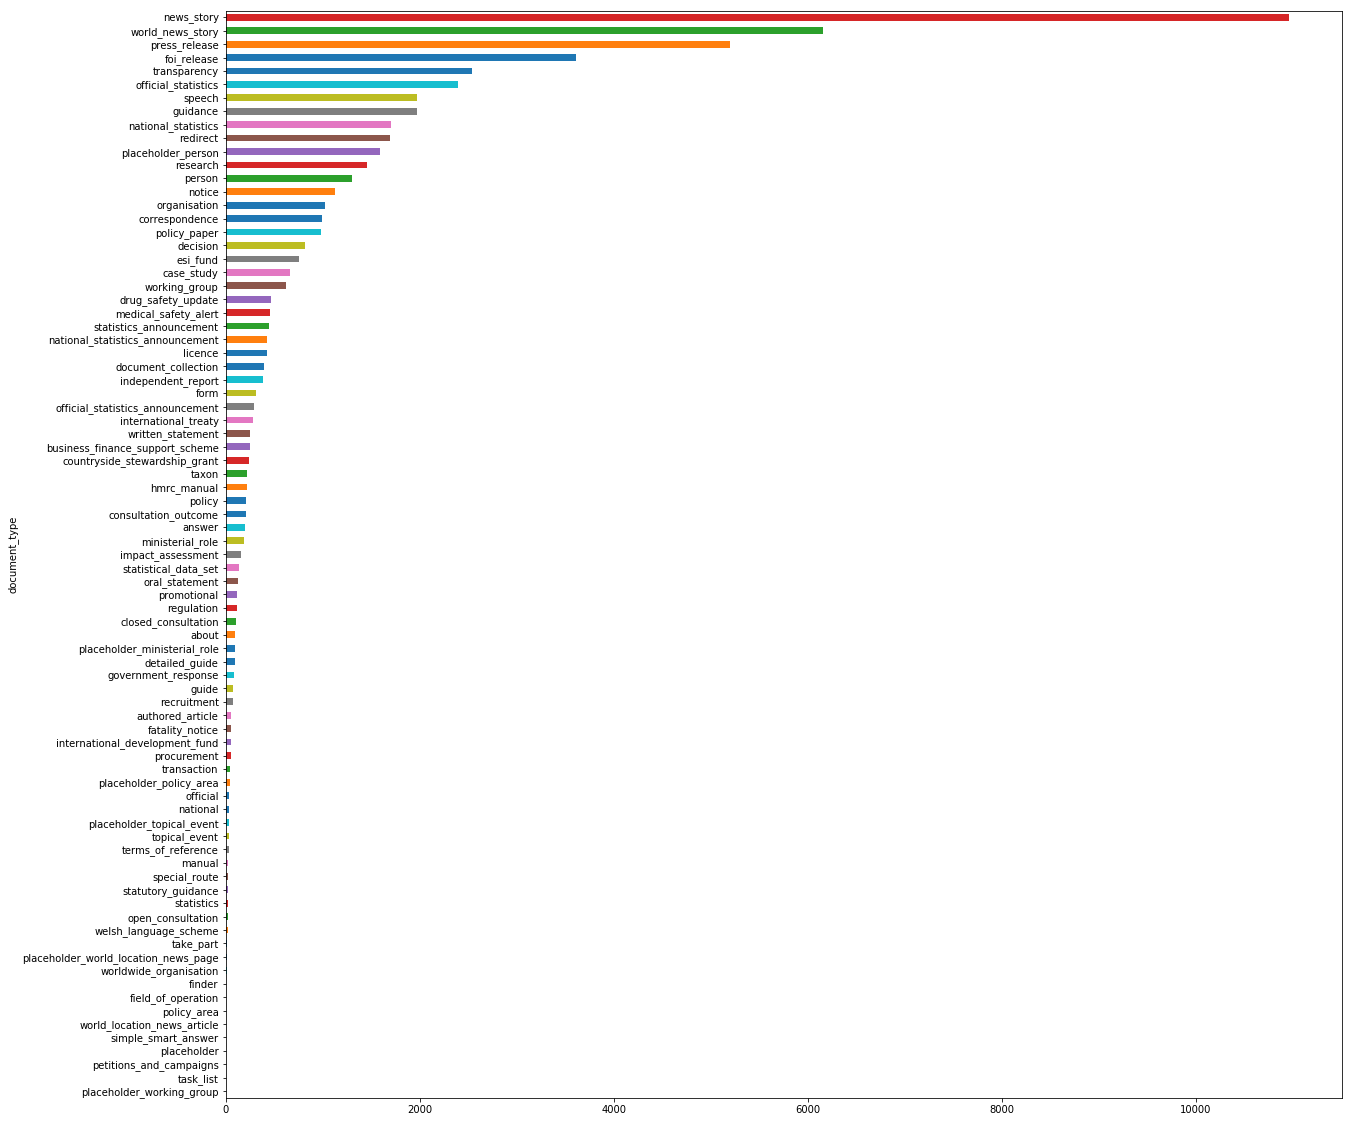

In [115]:
untagged.groupby('document_type').size().sort_values(ascending=True).plot(kind = 'barh', figsize=(20, 20))

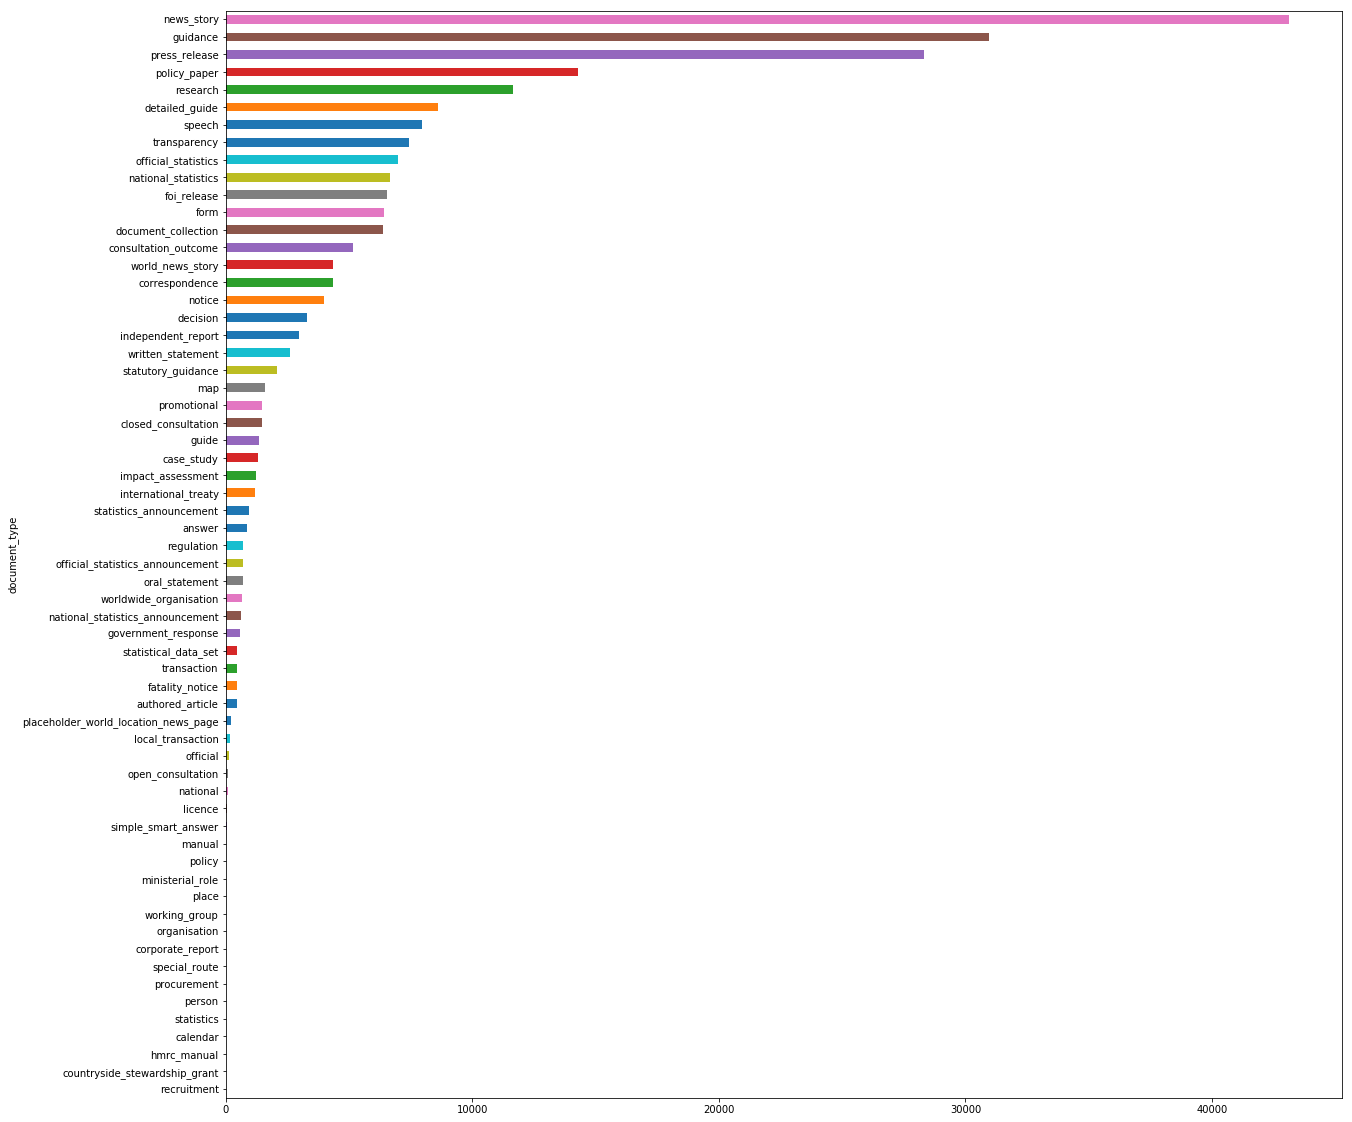

In [116]:
labelled.groupby('document_type').size().sort_values(ascending=True).plot(kind = 'barh', figsize=(20, 20))

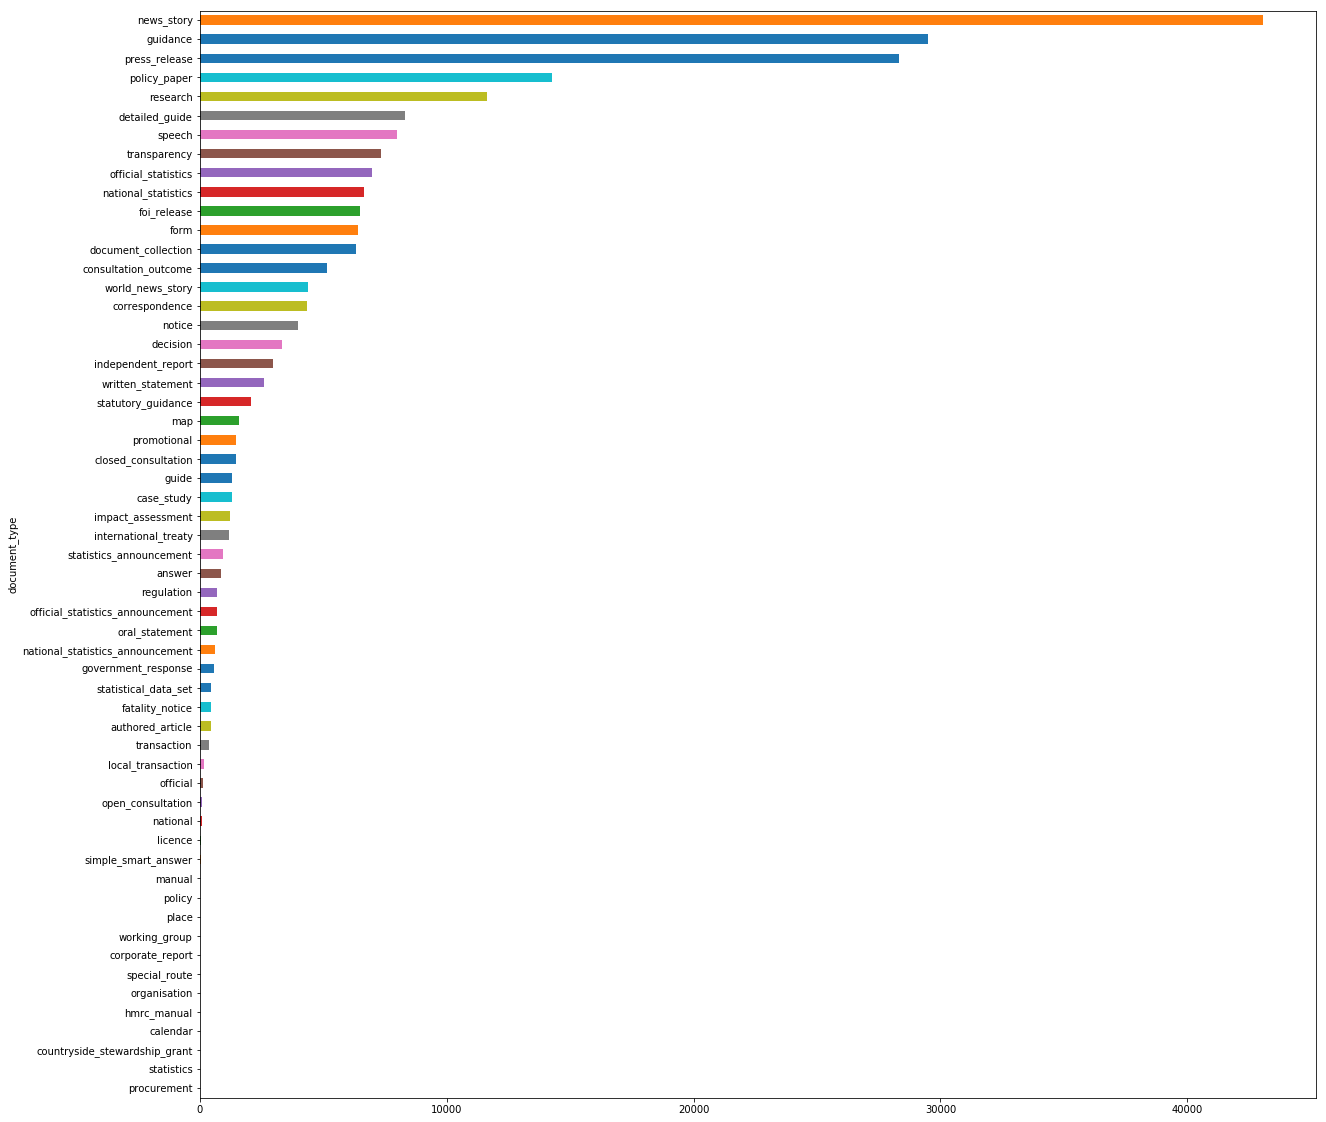

In [117]:
filtered.groupby('document_type').size().sort_values(ascending=True).plot(kind = 'barh', figsize=(20, 20))

### Observations/Conclusions
The untagged content appears to have a different distribution of document type compared to the tagged content, both before and after filtering the World/Corporate categories and deduplication. 

For example, relatively few guidance , policy paper and research documents are untagged. World_news_story, foi releases are over-represented in untagged data compared to tagged data.

This is likely to result in a drop inaccuracy when moving from modelling data to predicting for untagged data.

## Time series analyses of content type

What's the overall frequency of publications over time?

In [118]:
#untagged['first_published_at'].resample('Y').count().plot()

In [119]:
labelled.columns

Index(['Unnamed: 0', 'Unnamed: 0.1', 'base_path', 'content_id', 'description',
       'details', 'document_type', 'first_published_at', 'locale',
       'primary_publishing_organisation', 'publishing_app', 'title',
       'document_type_gp', 'body', 'combined_text', 'variable', 'taxon_id',
       'base_path_y', 'content_id_y', 'taxon_name', 'level1taxon',
       'level2taxon', 'level3taxon', 'level4taxon', '_merge'],
      dtype='object')

In [121]:
f_singlelabel = filtered.drop_duplicates('content_id').reset_index(drop=True)
print(f_singlelabel['first_published_at'][f_singlelabel['first_published_at'].str.contains('0001-01-01', na=False)])

f_singlelabel.drop(f_singlelabel.index[[75757]], inplace=True)
f_singlelabel['first_published_at'] = pd.to_datetime(f_singlelabel['first_published_at'])
f_singlelabel.index = f_singlelabel['first_published_at'] 

75757    0001-01-01T00:01:00.000+00:00
Name: first_published_at, dtype: object


In [122]:
l_singlelabel = labelled.drop_duplicates('content_id').reset_index(drop=True)


l_singlelabel['first_published_at'] = l_singlelabel['first_published_at'].str.replace('0001-01-01', '2001-01-01')

print(l_singlelabel['first_published_at'][l_singlelabel['first_published_at'].str.contains('0001-01-01', na=False)])

l_singlelabel.drop(l_singlelabel.index[[58843]], inplace=True)
l_singlelabel['first_published_at'] = pd.to_datetime(l_singlelabel['first_published_at'])
l_singlelabel.index = l_singlelabel['first_published_at'] 

Series([], Name: first_published_at, dtype: object)


Focus: since 2000

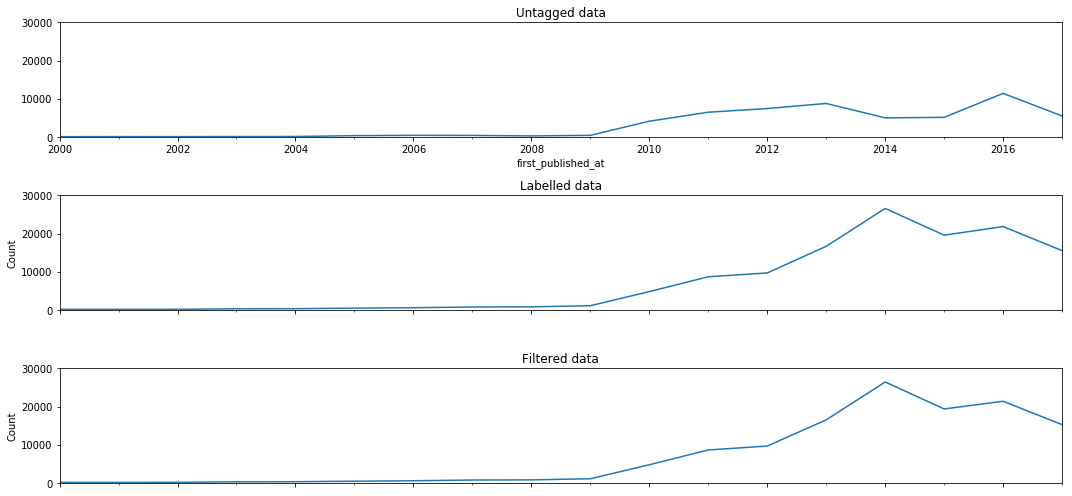

In [123]:
fig = plt.figure(figsize=(15, 7))

plt.subplot(3, 1, 1)
plt.title('Untagged data')
unlab = untagged['first_published_at'].resample('Y').count().plot()
unlab.set_xlim(pd.Timestamp('2000-12-31'), pd.Timestamp('2017-12-31'))
unlab.set_ylim([0, 30000])


plt.subplot(3, 1, 2)
lab=l_singlelabel['first_published_at'].resample('Y').count().plot()
lab.set_xlim(pd.Timestamp('2000-12-31'), pd.Timestamp('2017-12-31'))
plt.title('Labelled data')
plt.ylabel('Count')
lab.set_ylim([0, 30000])
lab.axes.get_xaxis().set_ticklabels([])
lab.set_xlabel('')


plt.subplot(3, 1, 3)
lab=f_singlelabel['first_published_at'].resample('Y').count().plot()
lab.set_xlim(pd.Timestamp('2000-12-31'), pd.Timestamp('2017-12-31'))
plt.title('Filtered data')
plt.ylabel('Count')
lab.set_ylim([0, 30000])
lab.axes.get_xaxis().set_ticklabels([])
lab.set_xlabel('')

fig.tight_layout()


### What's the publication frequency over time by document type?
### Unlabelled

In [124]:
grouped = untagged.groupby(['document_type', pd.Grouper(freq='Y')])['first_published_at'].count()
count_by_year = grouped.unstack('document_type', fill_value=0)

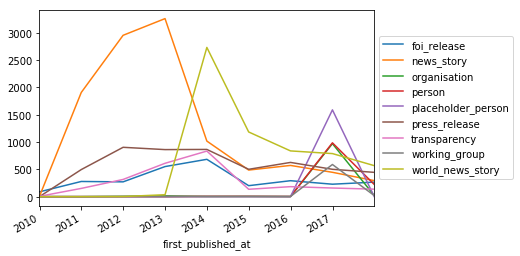

In [125]:
#There are too many document types to plot on one chart so select the types with highest maximum
top_count = count_by_year.loc[:,count_by_year.max() > 500]
ax = top_count.plot()
ax.set_xlim(pd.Timestamp('2009-12-31'), pd.Timestamp('2017-12-31'))
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))

In [126]:
#ax = grouped.unstack('document_type', fill_value=0).plot()
#ax.set_xlim(pd.Timestamp('2009-12-31'), pd.Timestamp('2017-12-31'))
#ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))

in order to compare distribution of document types over time with the labelled data, this needs to be relative not absolute. So change into percent of documents published that year

In [127]:
df = count_by_year.stack().reset_index()
df.columns = ['date', 'document_type', 'percent']
bydoctype_year = df.groupby(['date', 'document_type']).agg({'percent': 'sum'})
# Change: groupby state_office and divide by sum
bydoctype_pcts = bydoctype_year.groupby(level=0).apply(lambda x:
                                                 100 * x / float(x.sum())).unstack('document_type', fill_value=0)

bydoctype_pcts.columns = bydoctype_pcts.columns.droplevel(0)
bydoctype_pcts.columns

Index(['about', 'answer', 'authored_article',
       'business_finance_support_scheme', 'case_study', 'closed_consultation',
       'consultation_outcome', 'correspondence',
       'countryside_stewardship_grant', 'decision', 'detailed_guide',
       'document_collection', 'drug_safety_update', 'esi_fund',
       'fatality_notice', 'field_of_operation', 'finder', 'foi_release',
       'form', 'government_response', 'guidance', 'guide', 'hmrc_manual',
       'impact_assessment', 'independent_report',
       'international_development_fund', 'international_treaty', 'licence',
       'manual', 'medical_safety_alert', 'ministerial_role', 'national',
       'national_statistics', 'national_statistics_announcement', 'news_story',
       'notice', 'official', 'official_statistics',
       'official_statistics_announcement', 'open_consultation',
       'oral_statement', 'organisation', 'person', 'petitions_and_campaigns',
       'placeholder_ministerial_role', 'placeholder_person',
       'pla

In [128]:

top_pct = bydoctype_pcts.loc[:,bydoctype_pcts.max() > 15]
print(top_pct.columns.values)

top_pct = bydoctype_pcts[['correspondence', 'decision'
 , 'fatality_notice',  'foi_release',
  'guidance', 'independent_report', 'international_treaty', 'news_story', 'research', 'world_news_story']]


# ax = top_pct.plot(kind='area', stacked=True)

# ax.set_xlim(pd.Timestamp('2009-12-31'), pd.Timestamp('2017-12-31'))
# ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
# plt.title("Labelled data")

['correspondence' 'decision' 'fatality_notice' 'foi_release' 'guidance'
 'independent_report' 'international_treaty' 'news_story' 'research'
 'world_news_story']


### Labelled

In [129]:
l_grouped = l_singlelabel.groupby(['document_type', pd.Grouper(freq='Y')])['first_published_at'].count()
l_count_by_year = l_grouped.unstack('document_type', fill_value=0)

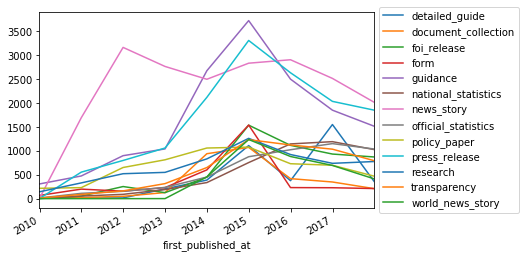

In [130]:
#There are too many document types to plot on one chart so select the types with highest maximum
l_top_count = l_count_by_year.loc[:,l_count_by_year.max() > 1000]
ax = l_top_count.plot()
ax.set_xlim(pd.Timestamp('2009-12-31'), pd.Timestamp('2017-12-31'))
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))

In [131]:
df_lab = l_count_by_year.stack().reset_index()
df_lab.columns = ['date', 'document_type', 'percent']
l_bydoctype_year = df_lab.groupby(['date', 'document_type']).agg({'percent': 'sum'})
# Change: groupby state_office and divide by sum
l_bydoctype_pcts = l_bydoctype_year.groupby(level=0).apply(lambda x:
                                                 100 * x / float(x.sum())).unstack('document_type', fill_value=0)

l_bydoctype_pcts.columns = l_bydoctype_pcts.columns.droplevel(0)

In [132]:
l_top_pct = l_bydoctype_pcts[['correspondence', 'decision'
 , 'fatality_notice',  'foi_release',
  'guidance', 'independent_report', 'international_treaty', 'news_story', 'research', 'world_news_story']]

# ax = utop_pct.plot(kind='area', stacked=True)
# plt.title('Unlabelled')
# ax.set_xlim(pd.Timestamp('2009-12-31'), pd.Timestamp('2017-12-31'))
# ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))

### Filtered

In [133]:
f_grouped = f_singlelabel.groupby(['document_type', pd.Grouper(freq='Y')])['first_published_at'].count()
f_count_by_year = f_grouped.unstack('document_type', fill_value=0)

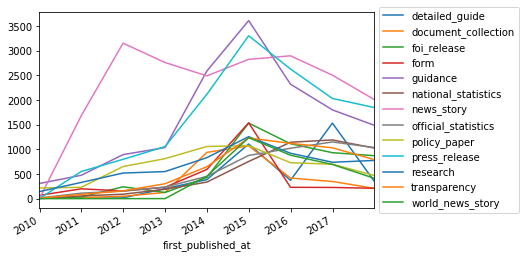

In [134]:
#There are too many document types to plot on one chart so select the types with highest maximum
f_top_count = f_count_by_year.loc[:,f_count_by_year.max() > 1000]
ax = f_top_count.plot()
ax.set_xlim(pd.Timestamp('2009-12-31'), pd.Timestamp('2017-12-31'))
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))

In [135]:
df_lab = f_count_by_year.stack().reset_index()
df_lab.columns = ['date', 'document_type', 'percent']
f_bydoctype_year = df_lab.groupby(['date', 'document_type']).agg({'percent': 'sum'})
# Change: groupby state_office and divide by sum
f_bydoctype_pcts = f_bydoctype_year.groupby(level=0).apply(lambda x:
                                                 100 * x / float(x.sum())).unstack('document_type', fill_value=0)

f_bydoctype_pcts.columns = f_bydoctype_pcts.columns.droplevel(0)

In [136]:
f_top_pct = f_bydoctype_pcts[['correspondence', 'decision'
 , 'fatality_notice',  'foi_release',
  'guidance', 'independent_report', 'international_treaty', 'news_story', 'research', 'world_news_story']]

# ax = utop_pct.plot(kind='area', stacked=True)
# plt.title('Unlabelled')
# ax.set_xlim(pd.Timestamp('2009-12-31'), pd.Timestamp('2017-12-31'))
# ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))

Text(0.5,1,'Filtered')

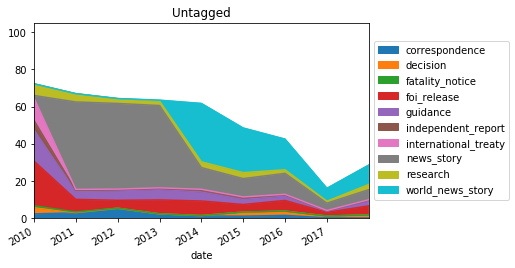

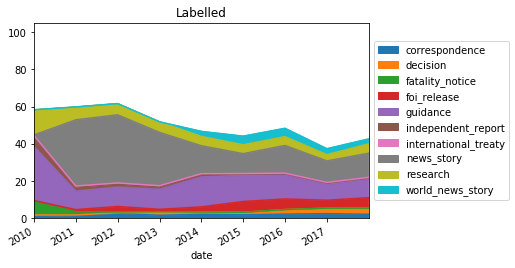

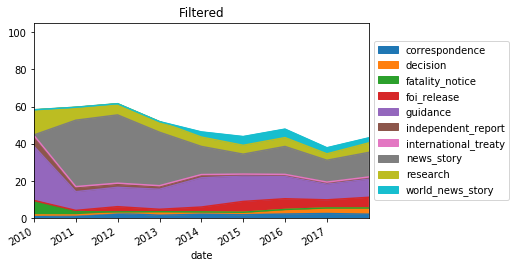

In [137]:
#Compare document type distribution over time beween cuntageed, labelled, filtered
ut = top_pct.plot(kind='area', stacked=True)
ut.set_xlim(pd.Timestamp('2009-12-31'), pd.Timestamp('2017-12-31'))
ut.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.title("Untagged")

lab = l_top_pct.plot(kind='area', stacked=True)
lab.set_xlim(pd.Timestamp('2009-12-31'), pd.Timestamp('2017-12-31'))
lab.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.title("Labelled")

filt = f_top_pct.plot(kind='area', stacked=True)
filt.set_xlim(pd.Timestamp('2009-12-31'), pd.Timestamp('2017-12-31'))
filt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.title("Filtered")

### Tagged to level1 only compared to level2 or lower in LABELLED data

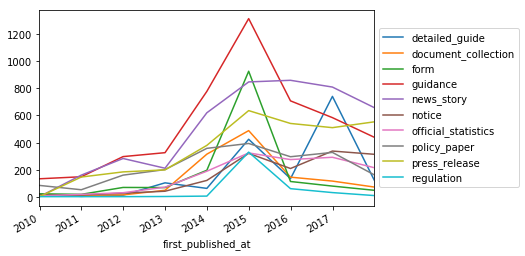

In [138]:
#level1
l1_grouped = level1_tagged.groupby(['document_type', pd.Grouper(freq='Y')])['first_published_at'].count()
l1_count_by_year = l1_grouped.unstack('document_type', fill_value=0)
#There are too many document types to plot on one chart so select the types with highest maximum
l1_top_count = l1_count_by_year.loc[:,l1_count_by_year.max() > 300]

ax = l1_top_count.plot()
ax.set_xlim(pd.Timestamp('2009-12-31'), pd.Timestamp('2017-12-31'))
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))

In [139]:
df_l1 = l1_count_by_year.stack().reset_index()
df_l1.columns = ['date', 'document_type', 'percent']
l1_bydoctype_year = df_l1.groupby(['date', 'document_type']).agg({'percent': 'sum'})
# Change: groupby state_office and divide by sum
l1_bydoctype_pcts = l1_bydoctype_year.groupby(level=0).apply(lambda x:
                                                 100 * x / float(x.sum())).unstack('document_type', fill_value=0)


l1_bydoctype_pcts.columns = l1_bydoctype_pcts.columns.droplevel(0)
l1_top_pct = l1_bydoctype_pcts.loc[:,l1_bydoctype_pcts.max() > 20]
l1_top_pct.columns.values

array(['decision', 'fatality_notice', 'guidance', 'independent_report',
       'international_treaty', 'national_statistics', 'notice',
       'policy_paper', 'research', 'statutory_guidance'], dtype=object)

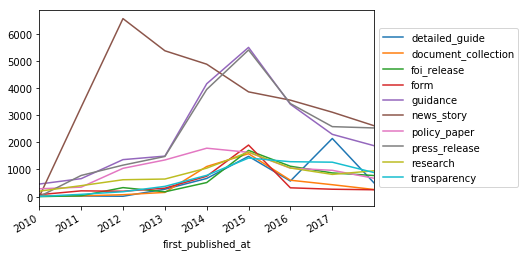

In [140]:
#level2
l2_grouped = level2_tagged.groupby(['document_type', pd.Grouper(freq='Y')])['first_published_at'].count()
l2_count_by_year = l2_grouped.unstack('document_type', fill_value=0)
#There are too many document types to plot on one chart so select the types with highest maximum
l2_top_count = l2_count_by_year.loc[:,l2_count_by_year.max() > 1400]

#Graph (absolute numbers)
ax = l2_top_count.plot()
ax.set_xlim(pd.Timestamp('2009-12-31'), pd.Timestamp('2017-12-31'))
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))

In [141]:
#Relative
df_l2 = l2_count_by_year.stack().reset_index()
df_l2.columns = ['date', 'document_type', 'percent']
l2_bydoctype_year = df_l2.groupby(['date', 'document_type']).agg({'percent': 'sum'})
# Change: groupby state_office and divide by sum
l2_bydoctype_pcts = l2_bydoctype_year.groupby(level=0).apply(lambda x:
                                                 100 * x / float(x.sum())).unstack('document_type', fill_value=0)

l2_bydoctype_pcts.columns = l2_bydoctype_pcts.columns.droplevel(0)

#To compare with labelled level1
l2_top_pct = l2_bydoctype_pcts[['decision', 'fatality_notice', 'guidance', 'independent_report',
       'international_treaty', 'national_statistics', 'notice',
       'policy_paper', 'research', 'statutory_guidance']]

Text(0.5,1,'Percent level2')

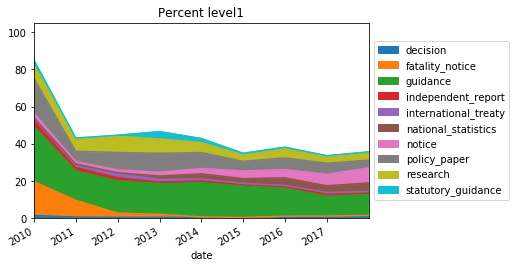

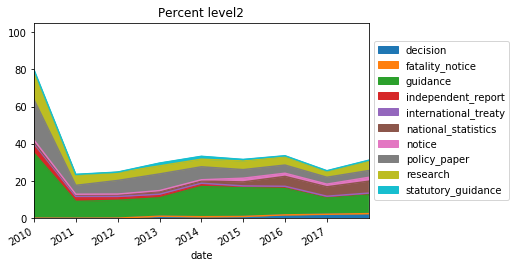

In [142]:
#Compare document type distribution over time beween content items tagged to level1 only and those tagged to level2 or lower
lev1 = l1_top_pct.plot(kind='area', stacked=True)
lev1.set_xlim(pd.Timestamp('2009-12-31'), pd.Timestamp('2017-12-31'))
lev1.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.title("Percent level1")

lev2 = l2_top_pct.plot(kind='area', stacked=True)
lev2.set_xlim(pd.Timestamp('2009-12-31'), pd.Timestamp('2017-12-31'))
lev2.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.title("Percent level2")

### Compare all populations on same 10 doc types 

In [143]:
#To compare with labelled level1
l1_top_pct = l1_bydoctype_pcts[['correspondence', 'decision'
 , 'fatality_notice',  'foi_release',
  'guidance', 'independent_report', 'international_treaty', 'news_story', 'research', 'world_news_story']]

l2_top_pct = l2_bydoctype_pcts[['correspondence', 'decision'
 , 'fatality_notice',  'foi_release',
  'guidance', 'independent_report', 'international_treaty', 'news_story', 'research', 'world_news_story']]

Text(0.5,1,'Percent level2')

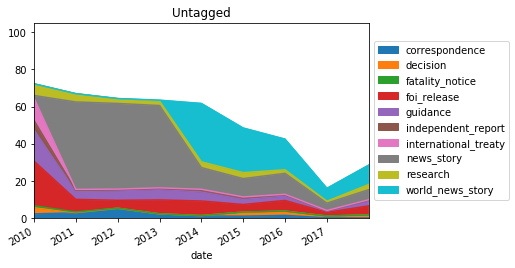

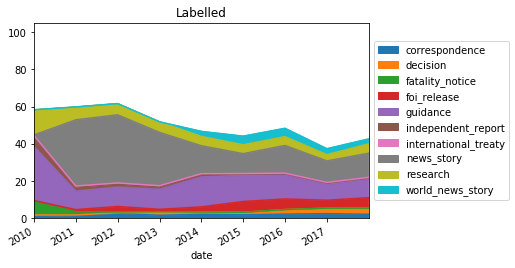

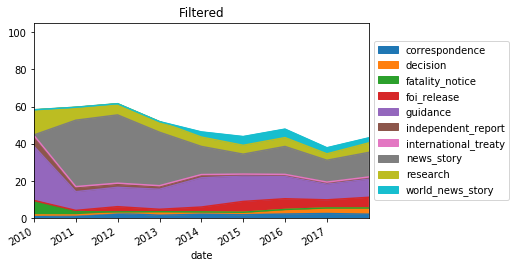

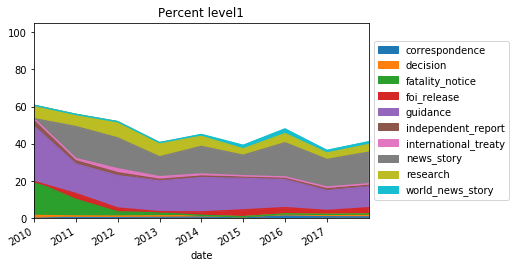

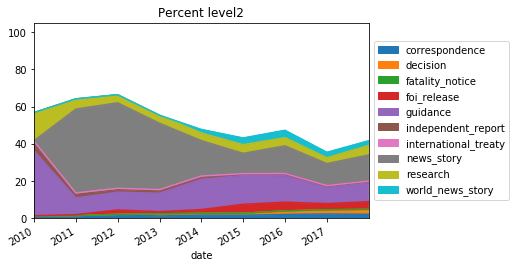

In [144]:
#Compare document type distribution over time beween cuntageed, labelled, filtered
ut = top_pct.plot(kind='area', stacked=True)
ut.set_xlim(pd.Timestamp('2009-12-31'), pd.Timestamp('2017-12-31'))
ut.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.title("Untagged")

lab = l_top_pct.plot(kind='area', stacked=True)
lab.set_xlim(pd.Timestamp('2009-12-31'), pd.Timestamp('2017-12-31'))
lab.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.title("Labelled")

filt = f_top_pct.plot(kind='area', stacked=True)
filt.set_xlim(pd.Timestamp('2009-12-31'), pd.Timestamp('2017-12-31'))
filt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.title("Filtered")

#Compare document type distribution over time beween content items tagged to level1 only and those tagged to level2 or lower
lev1 = l1_top_pct.plot(kind='area', stacked=True)
lev1.set_xlim(pd.Timestamp('2009-12-31'), pd.Timestamp('2017-12-31'))
lev1.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.title("Percent level1")

lev2 = l2_top_pct.plot(kind='area', stacked=True)
lev2.set_xlim(pd.Timestamp('2009-12-31'), pd.Timestamp('2017-12-31'))
lev2.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.title("Percent level2")

### Observations/conclusions
- Document distirbution changes over time with news stories decreasing in relative frequency
- There are substantial differences in document type composition between the untagged data and the filtered/labelled data particularly:
    - FOI releases more represented in untagged
    - guidance less represented in untagged
    - World news, especially recently, more represented in untagged
    - Fatality notices, have historically been less represented in untagged
- About half of content fell into these 10 categories in 2016
- ONly 20% of untagged content fell into these categories in 2017 (Are we waiting for an end of year publicaiton flurry?)

### Document type groupings
These groupings have been devised by need and could be used to supplement this analysis or interpretation
https://gov-uk.atlassian.net/wiki/spaces/GFED/pages/187564388/Grouping+document+types+by+need
- __News and announcements__
    - Updates & alerts
    - News (promotions)
    - Marketing
    - Speeches
- __Guidance__
   - Guidance
   - Contacts
- __Service__
   - Transactions
- __Outcomes__
   - Reports
   - Decisions
- __Transparency__
   - Engagement activities
   - Data
- __Organising entities__
   - Organising entities
   - Support
- __Out of scope__
   - Navigation pages
   - Lists
- __Stand alone__
   - Corporate info
   - Service manual

In [145]:
# #Consider grouping the individual doc types if further analyses required. 
# #This would be performed in the cleaning scripts, as below:
# def generate_doctype_gp(df):
#     df['doc_type_gp'] = 'other'
#     #NEWS&ANNOUNCEMENTS
#     #Update&alerts
#     df.loc[df['document_type'] == 'vehicle_recalls_and_faults_alert', 'doc_type_gp'] = 'news_and_announcements'
#     df.loc[df['document_type'] == 'fatality_notice', 'doc_type_gp'] = 'news_and_announcements'
#     df.loc[df['document_type'] == 'medical_safety_alert', 'doc_type_gp'] = 'news_and_announcements'
#     df.loc[df['document_type'] == 'drug_safety_update', 'doc_type_gp'] = 'news_and_announcements'
#     df.loc[df['document_type'] == 'statistics_announcement', 'doc_type_gp'] = 'news_and_announcements'
#     df.loc[df['document_type'] == 'staff_update', 'doc_type_gp'] = 'news_and_announcements'
#     df.loc[df['document_type'] == 'national_statistics_announcement', 'doc_type_gp'] = 'news_and_announcements'
#     df.loc[df['document_type'] == 'press_release', 'doc_type_gp'] = 'news_and_announcements'
#     df.loc[df['document_type'] == 'official_statistics_announcement', 'doc_type_gp'] = 'news_and_announcements'
#     #Mews(promotions)
#     df.loc[df['document_type'] == 'news_article', 'doc_type_gp'] = 'news_and_announcements'
#     df.loc[df['document_type'] == 'news_story', 'doc_type_gp'] = 'news_and_announcements'
#     df.loc[df['document_type'] == 'world_location_news_article', 'doc_type_gp'] = 'news_and_announcements'
#     df.loc[df['document_type'] == 'world_news_story', 'doc_type_gp'] = 'news_and_announcements'
#     df.loc[df['document_type'] == 'authored_article', 'doc_type_gp'] = 'news_and_announcements'
#     #Marketing
#     df.loc[df['document_type'] == 'promotional', 'doc_type_gp'] = 'news_and_announcements'
#     df.loc[df['document_type'] == 'coming_soon', 'doc_type_gp'] = 'news_and_announcements'
#     #Speeches
#     df.loc[df['document_type'] == 'oral_statement', 'doc_type_gp'] = 'news_and_announcements'
#     df.loc[df['document_type'] == 'speech', 'doc_type_gp'] = 'news_and_announcements'
#     df.loc[df['document_type'] == 'written_statement', 'doc_type_gp'] = 'news_and_announcements'



#     #Guidance
#     #guidance
#     df.loc[df['document_type'] == 'travel_advice', 'doc_type_gp'] = 'guidance'
#     df.loc[df['document_type'] == 'guide', 'doc_type_gp'] = 'guidance'
#     df.loc[df['document_type'] == 'calendar', 'doc_type_gp'] = 'guidance'
#     df.loc[df['document_type'] == 'answer', 'doc_type_gp'] = 'guidance'
#     df.loc[df['document_type'] == 'html_publication', 'doc_type_gp'] = 'guidance'
#     df.loc[df['document_type'] == 'detailed_guide', 'doc_type_gp'] = 'guidance'
#     df.loc[df['document_type'] == 'statuatory_guidance', 'doc_type_gp'] = 'guidance'
#     df.loc[df['document_type'] == 'specialist_document', 'doc_type_gp'] = 'guidance'
#     df.loc[df['document_type'] == 'manual', 'doc_type_gp'] = 'guidance'
#     df.loc[df['document_type'] == 'manual_section', 'doc_type_gp'] = 'guidance'
#     df.loc[df['document_type'] == 'hmrc_manual', 'doc_type_gp'] = 'guidance'
#     df.loc[df['document_type'] == 'hmrc_manual_section', 'doc_type_gp'] = 'guidance'
#     df.loc[df['document_type'] == 'topical_event_about_page', 'doc_type_gp'] = 'guidance'
#     #contacts
#     df.loc[df['document_type'] == 'contact', 'doc_type_gp'] = 'guidance'
    
    
#     #Service
#     #Transactions
#     df.loc[df['document_type'] == 'transaction', 'doc_type_gp'] = 'service'
#     df.loc[df['document_type'] == 'local_transaction', 'doc_type_gp'] = 'service'
#     df.loc[df['document_type'] == 'completed_transaction', 'doc_type_gp'] = 'service'
#     df.loc[df['document_type'] == 'form', 'doc_type_gp'] = 'service'
#     df.loc[df['document_type'] == 'calculator', 'doc_type_gp'] = 'service'
#     df.loc[df['document_type'] == 'smart_answer', 'doc_type_gp'] = 'service'
#     df.loc[df['document_type'] == 'simple_smart_answer', 'doc_type_gp'] = 'service'
#     df.loc[df['document_type'] == 'place', 'doc_type_gp'] = 'service'

    
#     #Outcomes
#     #Reports
#     df.loc[df['document_type'] == 'aaib_report', 'doc_type_gp'] = 'outcomes'
#     df.loc[df['document_type'] == 'maib_report', 'doc_type_gp'] = 'outcomes'
#     df.loc[df['document_type'] == 'raib_report', 'doc_type_gp'] = 'outcomes'
#     df.loc[df['document_type'] == 'financial_release', 'doc_type_gp'] = 'outcomes'
#     df.loc[df['document_type'] == 'service_standard_report', 'doc_type_gp'] = 'outcomes'
#     df.loc[df['document_type'] == 'regulation', 'doc_type_gp'] = 'outcomes'
#     df.loc[df['document_type'] == 'independent_report', 'doc_type_gp'] = 'outcomes'
#     df.loc[df['document_type'] == 'consultation_outcome', 'doc_type_gp'] = 'outcomes'
#     df.loc[df['document_type'] == 'impact_assessment', 'doc_type_gp'] = 'outcomes'
#     df.loc[df['document_type'] == 'procurement', 'doc_type_gp'] = 'outcomes'
#     df.loc[df['document_type'] == 'research', 'doc_type_gp'] = 'outcomes'
#     df.loc[df['document_type'] == 'case_study', 'doc_type_gp'] = 'outcomes'
#     #Decisions
#     df.loc[df['document_type'] == 'decision', 'doc_type_gp'] = 'outcomes'
#     df.loc[df['document_type'] == 'employment_tribunal_decision', 'doc_type_gp'] = 'outcomes'
#     df.loc[df['document_type'] == 'tax_tribunal_decision', 'doc_type_gp'] = 'outcomes'
#     df.loc[df['document_type'] == 'government_reponse', 'doc_type_gp'] = 'outcomes'
#     df.loc[df['document_type'] == 'utaac_decision', 'doc_type_gp'] = 'outcomes'
#     df.loc[df['document_type'] == 'dfid_research_output', 'doc_type_gp'] = 'outcomes'
#     df.loc[df['document_type'] == 'asylum_support_decision', 'doc_type_gp'] = 'outcomes'
#     df.loc[df['document_type'] == 'employment_appeal_tribunal_decision', 'doc_type_gp'] = 'outcomes'
#     df.loc[df['document_type'] == 'international_treaty', 'doc_type_gp'] = 'outcomes'

    
#     #Transparency
#     #Engagement Activities
#     df.loc[df['document_type'] == ' cma_case', 'doc_type_gp'] = 'transparency'
#     df.loc[df['document_type'] == 'open_consultation', 'doc_type_gp'] = 'transparency'
#     df.loc[df['document_type'] == 'closed_consultation', 'doc_type_gp'] = 'transparency'
#     df.loc[df['document_type'] == 'licence', 'doc_type_gp'] = 'transparency'
#     df.loc[df['document_type'] == 'notice', 'doc_type_gp'] = 'transparency'
#     df.loc[df['document_type'] == 'consultation', 'doc_type_gp'] = 'transparency'
#     #Data
#     df.loc[df['document_type'] == 'official_statistics', 'doc_type_gp'] = 'transparency'
#     df.loc[df['document_type'] == 'statistics', 'doc_type_gp'] = 'transparency'
#     df.loc[df['document_type'] == 'national_statistics', 'doc_type_gp'] = 'transparency'
#     df.loc[df['document_type'] == 'foi_release', 'doc_type_gp'] = 'transparency'
#     df.loc[df['document_type'] == 'transparency', 'doc_type_gp'] = 'transparency'
#     df.loc[df['document_type'] == 'correspondence', 'doc_type_gp'] = 'transparency'
#     df.loc[df['document_type'] == 'need', 'doc_type_gp'] = 'transparency'
    
   
#     #organising entities
#     #organising entities
#     df.loc[df['document_type'] == 'working_group', 'doc_type_gp'] = 'org_entities'
#     df.loc[df['document_type'] == 'organisation', 'doc_type_gp'] = 'org_entities'
#     df.loc[df['document_type'] == 'person', 'doc_type_gp'] = 'org_entities'
#     df.loc[df['document_type'] == 'worldwide_organisation', 'doc_type_gp'] = 'org_entities'
#     df.loc[df['document_type'] == 'world_location', 'doc_type_gp'] = 'org_entities'
#     df.loc[df['document_type'] == 'topical_event', 'doc_type_gp'] = 'org_entities'
#     df.loc[df['document_type'] == 'policy_area', 'doc_type_gp'] = 'org_entities'
#     df.loc[df['document_type'] == 'field_of_operation', 'doc_type_gp'] = 'org_entities'
#     df.loc[df['document_type'] == 'ministerial_role', 'doc_type_gp'] = 'org_entities'
#     #support
#     df.loc[df['document_type'] == 'international_development_fund', 'doc_type_gp'] = 'org_entities'
#     df.loc[df['document_type'] == 'countryside_stewardship_grant', 'doc_type_gp'] = 'org_entities'
#     df.loc[df['document_type'] == 'business_support', 'doc_type_gp'] = 'org_entities'
#     df.loc[df['document_type'] == 'esi_fund', 'doc_type_gp'] = 'org_entities'
#     df.loc[df['document_type'] == 'business_finance_support_scheme', 'doc_type_gp'] = 'org_entities'


    
#     #Out of scope
#     #Nav pages (thinks these were removed by devs)
#     df.loc[df['document_type'] == 'finder_email_signup', 'doc_type_gp'] = 'oo_scope'
#     df.loc[df['document_type'] == 'mainstream_browse_page', 'doc_type_gp'] = 'oo_scope'
#     df.loc[df['document_type'] == 'topic', 'doc_type_gp'] = 'oo_scope'
#     df.loc[df['document_type'] == 'take_part', 'doc_type_gp'] = 'oo_scope'
#     df.loc[df['document_type'] == 'homepage', 'doc_type_gp'] = 'oo_scope'
#     df.loc[df['document_type'] == 'licence_finder', 'doc_type_gp'] = 'oo_scope'
#     df.loc[df['document_type'] == 'search', 'doc_type_gp'] = 'oo_scope'
#     df.loc[df['document_type'] == 'taxon ', 'doc_type_gp'] = 'oo_scope'
#     #Lists
#     df.loc[df['document_type'] == 'travel_advice_index', 'doc_type_gp'] = 'oo_scope'
#     df.loc[df['document_type'] == 'document_collection', 'doc_type_gp'] = 'oo_scope'
#     df.loc[df['document_type'] == 'business_support_finder', 'doc_type_gp'] = 'oo_scope'
#     df.loc[df['document_type'] == 'finder', 'doc_type_gp'] = 'oo_scope'
#     #Ways to deliver info
#     df.loc[df['document_type'] == 'map', 'doc_type_gp'] = 'oo_scope'
#     df.loc[df['document_type'] == 'video', 'doc_type_gp'] = 'oo_scope'
#     df.loc[df['document_type'] == 'email_alert_signup', 'doc_type_gp'] = 'oo_scope'
    

#     #Standalone
#     #Corporate info
#     df.loc[df['document_type'] == 'about', 'doc_type_gp'] = 'standalone'
#     df.loc[df['document_type'] == 'about_our_services', 'doc_type_gp'] = 'standalone'
#     df.loc[df['document_type'] == 'personal_information_charter', 'doc_type_gp'] = 'standalone'
#     df.loc[df['document_type'] == 'equality_and_diversity', 'doc_type_gp'] = 'standalone'
#     df.loc[df['document_type'] == 'our_governance', 'doc_type_gp'] = 'standalone'
#     df.loc[df['document_type'] == 'services_and_information', 'doc_type_gp'] = 'standalone'
#     df.loc[df['document_type'] == 'our_energy_use', 'doc_type_gp'] = 'standalone'
#     df.loc[df['document_type'] == 'corporate_report', 'doc_type_gp'] = 'standalone'
#     df.loc[df['document_type'] == 'social_media_use', 'doc_type_gp'] = 'standalone'
#     df.loc[df['document_type'] == 'access_and_opening', 'doc_type_gp'] = 'standalone'
#     df.loc[df['document_type'] == 'membership', 'doc_type_gp'] = 'standalone'
#     df.loc[df['document_type'] == 'publication_scheme', 'doc_type_gp'] = 'standalone'
#     df.loc[df['document_type'] == 'media_enquiries', 'doc_type_gp'] = 'standalone'
#     df.loc[df['document_type'] == 'complaints_procedure', 'doc_type_gp'] = 'standalone'
#     df.loc[df['document_type'] == 'help_page', 'doc_type_gp'] = 'standalone'
#     #Service manual
#     df.loc[df['document_type'] == 'service_manual_homepage', 'doc_type_gp'] = 'standalone'
#     df.loc[df['document_type'] == 'service_manual_service_toolkit', 'doc_type_gp'] = 'standalone'
#     df.loc[df['document_type'] == 'service_manual_service_standard', 'doc_type_gp'] = 'standalone'
#     df.loc[df['document_type'] == 'service_manual_guide', 'doc_type_gp'] = 'standalone'
#     df.loc[df['document_type'] == 'service_manual_topic', 'doc_type_gp'] = 'standalone'
   

    
#     return df



In [146]:
#functions not working and already spent a while cut-and-pasting so...
# def recode_doctype_gp(df, document_type, doctype_gp):
#     df.loc[df['document_type'] == 'document_type', 'doc_type_gp'] = 'doctype_gp'
    
#     return df


# def generate_doctype_gp_test(df):
#     df['doctype_gp'] = df['document_type']
    
#     df = recode_doctype_gp(df, 'fatality_notice', 'news_and_announcements')
#     return df


In [147]:
# untagged = generate_doctype_gp(untagged).copy()
# labelled = generate_doctype_gp(l_singlelabel).copy()
# filtered = generate_doctype_gp(f_singlelabel).copy()

In [151]:
grouped = untagged.groupby(['document_type_gp', pd.Grouper(freq='Y')])['first_published_at'].count()
count_by_year = grouped.unstack('document_type_gp', fill_value=0)

l_grouped = l_singlelabel.groupby(['document_type_gp', pd.Grouper(freq='Y')])['first_published_at'].count()
l_count_by_year = l_grouped.unstack('document_type_gp', fill_value=0)

f_grouped = f_singlelabel.groupby(['document_type_gp', pd.Grouper(freq='Y')])['first_published_at'].count()
f_count_by_year = f_grouped.unstack('document_type_gp', fill_value=0)

Text(0.5,1,'Filtered')

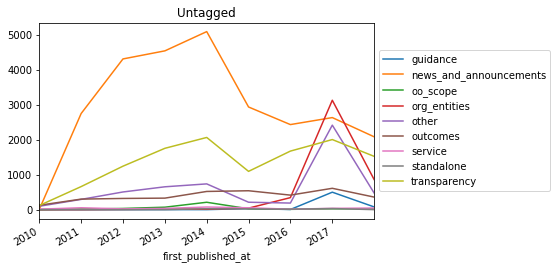

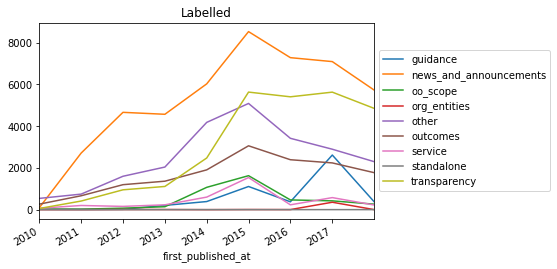

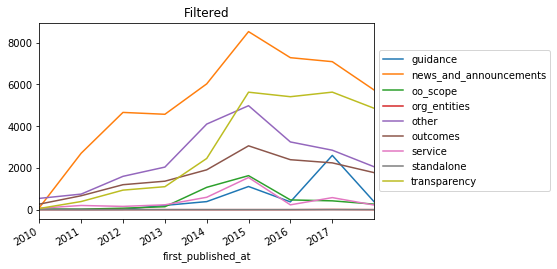

In [152]:
ax = count_by_year.plot()
ax.set_xlim(pd.Timestamp('2009-12-31'), pd.Timestamp('2017-12-31'))
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.title("Untagged")

lab = l_count_by_year.plot()
lab.set_xlim(pd.Timestamp('2009-12-31'), pd.Timestamp('2017-12-31'))
lab.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.title("Labelled")

filt = f_count_by_year.plot()
filt.set_xlim(pd.Timestamp('2009-12-31'), pd.Timestamp('2017-12-31'))
filt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.title("Filtered")

__----------------CREATE DICTIONARY LOOKUP FOR DOCUMENT TYPE GROUP----------------------__

In [153]:
x = dict(zip(labelled.document_type, labelled.document_type_gp,))
y = dict(zip(untagged.document_type, untagged.document_type_gp))

In [154]:
def merge_two_dicts(x, y):
    """Given two dicts, merge them into a new dict as a shallow copy."""
    z = x.copy()
    z.update(y)
    return z

In [155]:
lookup_doctype_gp = merge_two_dicts(x, y)

In [156]:
lookup_doctype_gp

{'about': 'standalone',
 'answer': 'guidance',
 'authored_article': 'news_and_announcements',
 'business_finance_support_scheme': 'org_entities',
 'calendar': 'guidance',
 'case_study': 'outcomes',
 'closed_consultation': 'transparency',
 'consultation_outcome': 'outcomes',
 'corporate_report': 'standalone',
 'correspondence': 'transparency',
 'countryside_stewardship_grant': 'org_entities',
 'decision': 'outcomes',
 'detailed_guide': 'guidance',
 'document_collection': 'oo_scope',
 'drug_safety_update': 'news_and_announcements',
 'esi_fund': 'org_entities',
 'fatality_notice': 'news_and_announcements',
 'field_of_operation': 'org_entities',
 'finder': 'oo_scope',
 'foi_release': 'transparency',
 'form': 'service',
 'government_response': 'other',
 'guidance': 'other',
 'guide': 'guidance',
 'hmrc_manual': 'guidance',
 'impact_assessment': 'outcomes',
 'independent_report': 'outcomes',
 'international_development_fund': 'org_entities',
 'international_treaty': 'outcomes',
 'licence': '

In [157]:
labelled["test"] = labelled["document_type"].map(lookup_doctype_gp)

In [158]:
labelled

,Unnamed: 0,Unnamed: 0.1,base_path,content_id,description,details,document_type,first_published_at,locale,primary_publishing_organisation,...,taxon_id,base_path_y,content_id_y,taxon_name,level1taxon,level2taxon,level3taxon,level4taxon,_merge,test
0,5,1.0,/student-finance-register-login,e57daef4-5eb5-431c-b0ad-14119ab0355f,your student finance online account - check pa...,{'introductory_paragraph': '<p>Sign in or regi...,transaction,2016-02-29T09:24:10.000+00:00,en,NaN,...,64aa6eec-48b5-481d-9131-9c8b6326eea1,/education/student-grants-bursaries-scholarships,64aa6eec-48b5-481d-9131-9c8b6326eea1,"Student grants, bursaries and scholarships","Education, training and skills",Funding and finance for students,"Student grants, bursaries and scholarships",NaN,both,service
1,6,50.0,/student-finance-calculator,434b6eb5-33c8-4300-aba3-f5ead58600b8,student finance calculator - get a quick estim...,{'transaction_start_link': '/student-finance-c...,transaction,2016-02-29T09:24:10.000+00:00,en,NaN,...,64aa6eec-48b5-481d-9131-9c8b6326eea1,/education/student-grants-bursaries-scholarships,64aa6eec-48b5-481d-9131-9c8b6326eea1,"Student grants, bursaries and scholarships","Education, training and skills",Funding and finance for students,"Student grants, bursaries and scholarships",NaN,both,service
2,7,51.0,/apply-online-for-student-finance,83155b50-418e-437c-9389-cf0e1302900f,apply online for student finance - online appl...,{'introductory_paragraph': '<p>If you’re a stu...,transaction,2016-02-29T09:24:10.000+00:00,en,NaN,...,64aa6eec-48b5-481d-9131-9c8b6326eea1,/education/student-grants-bursaries-scholarships,64aa6eec-48b5-481d-9131-9c8b6326eea1,"Student grants, bursaries and scholarships","Education, training and skills",Funding and finance for students,"Student grants, bursaries and scholarships",NaN,both,service
3,8,300.0,/student-finance,d38bafd3-2c46-4be2-b50b-50c2ba7d30ed,student finance - student loans or student gra...,{'external_related_links': [{'url': 'http://me...,guide,2016-02-29T09:24:10.000+00:00,en,NaN,...,64aa6eec-48b5-481d-9131-9c8b6326eea1,/education/student-grants-bursaries-scholarships,64aa6eec-48b5-481d-9131-9c8b6326eea1,"Student grants, bursaries and scholarships","Education, training and skills",Funding and finance for students,"Student grants, bursaries and scholarships",NaN,both,guidance
4,9,375.0,/apply-for-student-finance,06017464-d3e2-4a4c-8bef-250eff0de7e4,how to apply for student finance - when to app...,"{'external_related_links': [], 'parts': [{'slu...",guide,2016-02-29T09:24:10.000+00:00,en,NaN,...,64aa6eec-48b5-481d-9131-9c8b6326eea1,/education/student-grants-bursaries-scholarships,64aa6eec-48b5-481d-9131-9c8b6326eea1,"Student grants, bursaries and scholarships","Education, training and skills",Funding and finance for students,"Student grants, bursaries and scholarships",NaN,both,guidance
5,10,455.0,/1619-bursary-fund,f4b96a38-5247-4afd-b554-8a258a0e8c93,bursaries of up to £1 200 for students in furt...,"{'external_related_links': [], 'parts': [{'slu...",guide,2016-02-29T09:24:10.000+00:00,en,NaN,...,64aa6eec-48b5-481d-9131-9c8b6326eea1,/education/student-grants-bursaries-scholarships,64aa6eec-48b5-481d-9131-9c8b6326eea1,"Student grants, bursaries and scholarships","Education, training and skills",Funding and finance for students,"Student grants, bursaries and scholarships",NaN,both,guidance
6,11,493.0,/extra-money-pay-university,eff0d788-3b5e-4090-8b56-aaa0a4bf3f25,bursaries and scholarships from universities o...,"{'external_related_links': [], 'parts': [{'slu...",guide,2016-02-29T09:24:10.000+00:00,en,NaN,...,64aa6eec-48b5-481d-9131-9c8b6326eea1,/education/student-grants-bursaries-scholarships,64aa6eec-48b5-481d-9131-9c8b6326eea1,"Student grants, bursaries and scholarships","Education, training and skills",Funding and finance for students,"Student grants, bursaries and scholarships",NaN,both,guidance
7,12,608.0,/nhs-bursaries,6a131bf3-6d52-4512-98cc-348c243fba8f,nhs bursary and grants for medicine dentistry ...

In [159]:
import json
with open('../../data/document_type_group_lookup.json', 'w') as fp:
    json.dump(lookup_doctype_gp, fp)